In this class, we will talk about model explainability but more in the context of data explainability or root cause analysis. In many cases building a very good machine learning model is not an ultimate goal. What is really wanted is the data understanding. A factory wants to know why the product is plagued with a defect, not to predict afterward if there is a defect or not. A football team wants to know which position is the best for scoring a goal, not what's the probability of scoring from a given position. And even when they want a prediction they would love to see the justification to trust the model. Often a nice plot is worth more than sophisticated machine-learning approaches.

In [194]:
import pandas as pd
import numpy as np
import dalex as dx
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import load_wine

In [195]:
data = load_wine()

In [196]:
data
df = pd.DataFrame(data['data'], columns=data['feature_names'])
y = data['target']
df['target'] = y

You should already be familiar with many data visualization techniques so we will not train it now. I just want to share a less popular type of data analysis. Usually plotting the target against any feature is not helpful but after some modification, we might be able to see some patterns. 

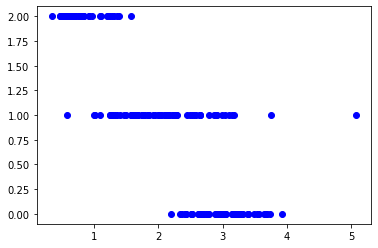

In [197]:
plt.plot(df.flavanoids, y, 'bo')

For each value, we can plot the average target for data:
 - below that value
 - above that value
 - around that value
 
Please note that for the line "above that value" the more left we go the higher fraction of data is covered. The same with the "below that value"

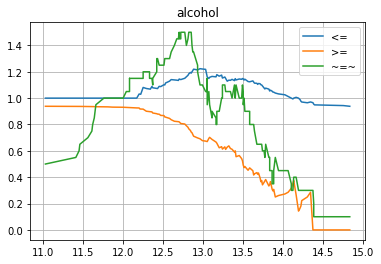

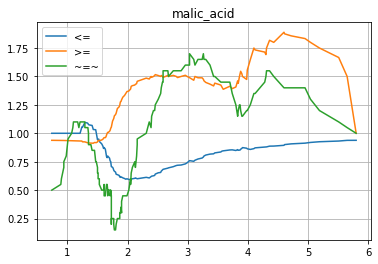

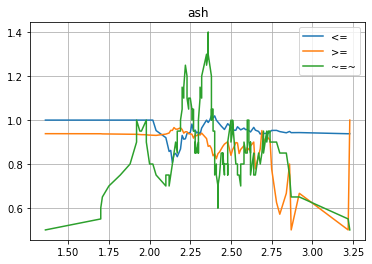

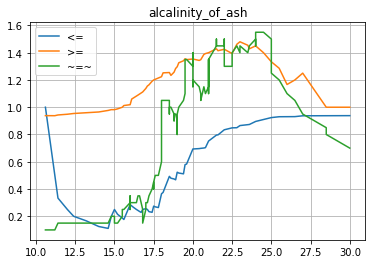

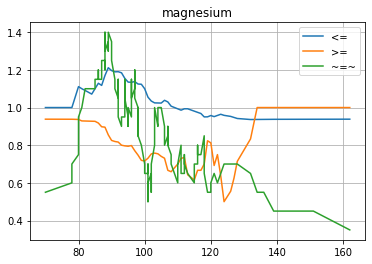

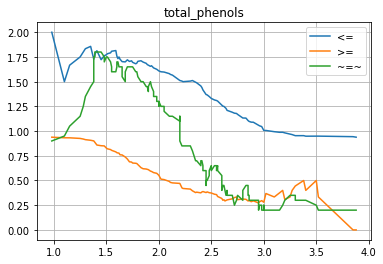

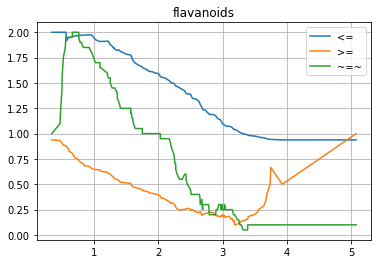

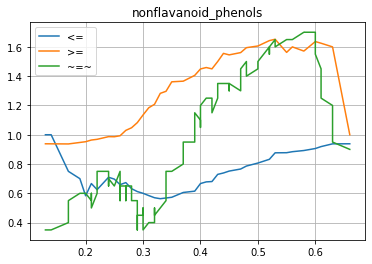

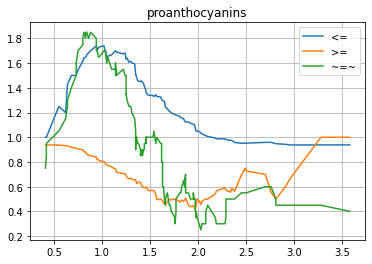

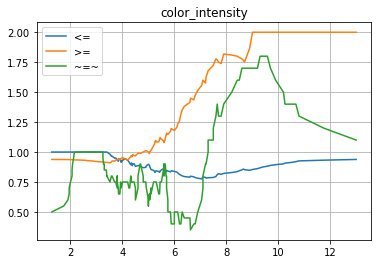

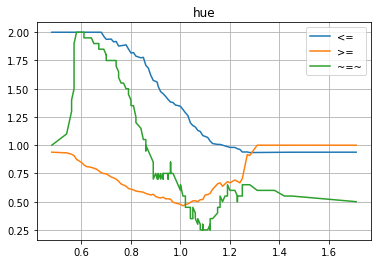

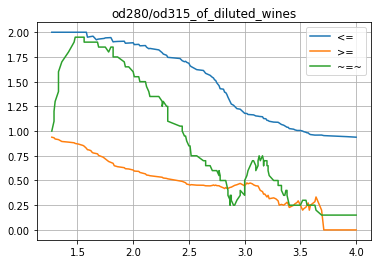

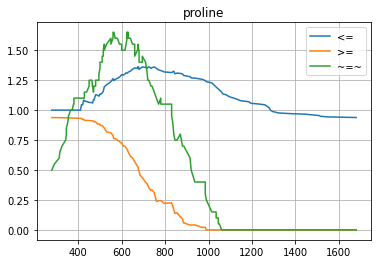

In [198]:
for col in df.columns.drop('target'):
    tmp = df.sort_values(col)
    plt.title(col)
    plt.plot(tmp[col], tmp[col].apply(lambda x: tmp[tmp[col] <= x].target.mean()), label="<=")
    plt.plot(tmp[col], tmp[col].apply(lambda x: tmp[tmp[col] >= x].target.mean()), label=">=")
    plt.plot(tmp[col], np.convolve(np.ones(20)/20, tmp.target, mode='same'), label= "~=~")
    plt.legend()
    plt.grid()
    plt.show()

Ok, let's just train a model. We are not interested in top performance right now so we will skip hyperparameter optimization. Also, we want to find the pattern in the data we have, so we don't split the data into validation and test set.

In [199]:
model = RandomForestRegressor()
x = df.drop('target', axis=1)
y = df.target
model.fit(x, y)

RandomForestRegressor()

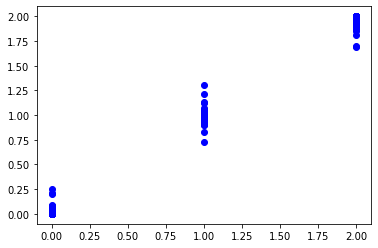

In [200]:
plt.plot(df.target, model.predict(x), 'bo')

Dalex is a python package for model explainability. We will use some of its functions to understand the data and the model better. First, we need to create an explainer model. Since we are not interested in checking the model performance but the relation between the data and the target we will use the whole dataset here. In the first case, we might want to use the testing set.

In [201]:
exp = dx.Explainer(model, x, y)

Preparation of a new explainer is initiated

  -> data              : 178 rows 13 cols
  -> target variable   : Parameter 'y' was a pandas.Series. Converted to a numpy.ndarray.
  -> target variable   : 178 values
  -> model_class       : sklearn.ensemble._forest.RandomForestRegressor (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function yhat_default at 0x00000189FFDB3130> will be used (default)
  -> predict function  : Accepts pandas.DataFrame and numpy.ndarray.
  -> predicted values  : min = 0.0, mean = 0.932, max = 2.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -0.3, mean = 0.00618, max = 0.31
  -> model_info        : package sklearn

A new explainer has been created!


c:\Users\samue\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\base.py:450: UserWarning:

X does not have valid feature names, but RandomForestRegressor was fitted with feature names



In [202]:
fi = exp.model_parts()

The first step will be feature importance. It's a basic analysis where we calculate the global impact of a feature. The idea in dalex default approach is to measure how much the model performance is worsening after removing this feature. Of course, it would require retraining the model, the optimal set of hyperparameters might be different and it might affect the results. To avoid these problems we do not retrain the model. Instead, we simulate its removal by assigning random values to it. To make it more realistic the values are not completely random, we just shuffle this column in a dataframe, do the prediction, check performance and repeat these steps multiple times.

In [203]:
fi.plot()

Another useful tool is a partial dependency plot. For a given feature we observe what's the average output of our model for different values of this feature. For each considered value we set this value for each row in our dataframe and calculate an average prediction.

In [204]:
exp.model_profile().plot()

Calculating ceteris paribus: 100%|██████████| 13/13 [00:00<00:00, 32.41it/s]



We can also create similar plots for single rows. Here for each column, we present what would be the output from the model assuming we keep all remaining values and change the value of this one selected feature.

In [205]:
exp.predict_profile(x.iloc[[15,80]]).plot()

Calculating ceteris paribus: 100%|██████████| 13/13 [00:00<00:00, 121.93it/s]


SHAP values are equivalents of Shapley values for the predictive models. It estimates the effect of a particular value of a particular feature for a prediction of a considered row. It's also done by replacing this value with proper sampling and replacing this value and measuring the effect on the prediction.

In [206]:
exp.predict_parts(x.iloc[15], type='shap').plot()

In [207]:
exp.predict_parts(x.iloc[15], type='shap').plot()

The result is based on sampling so the result for the same row can vary

In [208]:
exp.predict_parts(x.iloc[88], type='shap').plot()

In [209]:
exp.predict_parts(x.iloc[88], type='shap').result

,variable,contribution,variable_name,variable_value,sign,label,B
0,proline = 680.0,0.164888,proline,680.00,1.0,RandomForestRegressor,1
1,flavanoids = 1.69,-0.111404,flavanoids,1.69,-1.0,RandomForestRegressor,1
2,nonflavanoid_phenols = 0.48,-0.000787,nonflavanoid_phenols,0.48,-1.0,RandomForestRegressor,1
3,od280/od315_of_diluted_wines = 2.75,-0.060843,od280/od315_of_diluted_wines,2.75,-1.0,RandomForestRegressor,1
4,color_intensity = 2.8,-0.036124,color_intensity,2.80,-1.0,RandomForestRegressor,1
...,...,...,...,...,...,...,...
8,total_phenols = 1.95,0.002708,total_phenols,1.95,1.0,RandomForestRegressor,0
9,proanthocyanins = 1.35,-0.002045,proanthocyanins,1.35,-1.0,RandomForestRegressor,0
10,alcalinity_of_ash = 21.6,0.001249,alcalinity_of_ash,21.60,1.0,RandomForestRegressor,0
11,nonflavanoid_phenols = 0.48,0.000445,nonflavanoid_phenols,0.48,1.0,RandomForestRegressor,0


**Task** For each class find the most representative examples and plot breakdown for them.

Imagine we have a model classifying dogs and cats. Then a good example would be to show e.g. 3 breeds of dogs and the same with cats. Showing 5 golden retrievers although cute is not the best approach.

In [216]:
# calculate centroids for each class
centroids = df.groupby('target').mean()
centroids

closest_indices = []

# Iterate through each class
for target, centroid in centroids.iterrows():
    # Filter samples of the current class
    samples_of_class = df[df['target'] == target].drop(columns='target')
    
    # Compute distances of each sample to the centroid
    distances = np.linalg.norm(samples_of_class.values - centroid.values, axis=1)
    
    # Get the index of the closest sample
    closest_example_idx = samples_of_class.index[np.argmin(distances)]
    
    # Append to the list
    closest_indices.append(closest_example_idx)

print(closest_indices)


[55, 84, 154]


In [218]:
for idx in closest_indices:
    exp.predict_parts(x.iloc[idx]).plot()

There are other approaches that can be used for model explainability.
 - LIME - approximating model locally by a linear model
 - Anchor - approximating model locally by a rule-based model
 - Prototype - justifying a new prediction by showing a similar known row (a prototype)
 - Counterfactual Explanation - showing a similar know row with a different prediction to show what must be changed to change the prediction.

# Task

- take a dataset you want
- perform an exploratory data analysis (data visualization)
- create a pipeline for data preprocessing
- add new features (one hot encoding for example)
- add predictive model as the last step of the pipeline
- prepare a report with model explainability

Send it to gmiebs@cs.put.poznan.pl within 144 hours after the class is finished. Start the subject of the email with [IR]

In [212]:
%pip install ucimlrepo

^C
Note: you may need to restart the kernel to use updated packages.


In [ ]:
from ucimlrepo import fetch_ucirepo 

In [ ]:
# fetch dataset 
car_evaluation = fetch_ucirepo(id=19) 
  
# data (as pandas dataframes) 
X = car_evaluation.data.features 
y = car_evaluation.data.targets 
  
# metadata 
print(car_evaluation.metadata) 
  
# variable information 
print(car_evaluation.variables) 

{'uci_id': 19, 'name': 'Car Evaluation', 'repository_url': 'https://archive.ics.uci.edu/dataset/19/car+evaluation', 'data_url': 'https://archive.ics.uci.edu/static/public/19/data.csv', 'abstract': 'Derived from simple hierarchical decision model, this database may be useful for testing constructive induction and structure discovery methods.', 'area': 'Other', 'tasks': ['Classification'], 'characteristics': ['Multivariate'], 'num_instances': 1728, 'num_features': 6, 'feature_types': ['Categorical'], 'demographics': [], 'target_col': ['class'], 'index_col': None, 'has_missing_values': 'no', 'missing_values_symbol': None, 'year_of_dataset_creation': 1988, 'last_updated': 'Thu Aug 10 2023', 'dataset_doi': '10.24432/C5JP48', 'creators': ['Marko Bohanec'], 'intro_paper': {'title': 'Knowledge acquisition and explanation for multi-attribute decision making', 'authors': 'M. Bohanec, V. Rajkovič', 'published_in': '8th Intl Workshop on Expert Systems and their Applications, Avignon, France', 'yea

In [ ]:
# change y column name from 'class' to 'target'
y = y.rename(columns={'class': 'target'})
y

,target
0,unacc
1,unacc
2,unacc
3,unacc
4,unacc
...,...
1723,good
1724,vgood
1725,unacc
1726,good


In [ ]:
X

,buying,maint,doors,persons,lug_boot,safety
0,vhigh,vhigh,2,2,small,low
1,vhigh,vhigh,2,2,small,med
2,vhigh,vhigh,2,2,small,high
3,vhigh,vhigh,2,2,med,low
4,vhigh,vhigh,2,2,med,med
...,...,...,...,...,...,...
1723,low,low,5more,more,med,med
1724,low,low,5more,more,med,high
1725,low,low,5more,more,big,low
1726,low,low,5more,more,big,med


In [ ]:
df = pd.concat([X, y], axis=1)

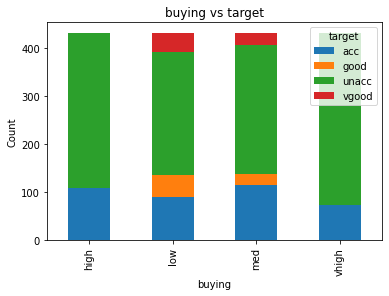

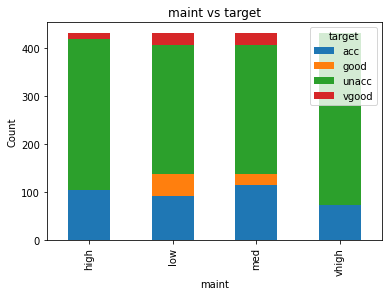

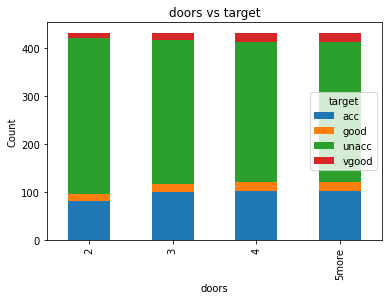

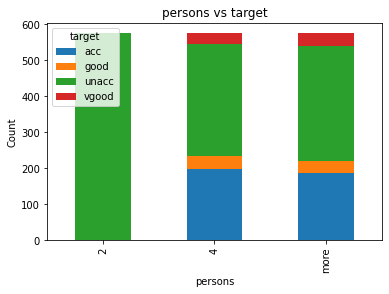

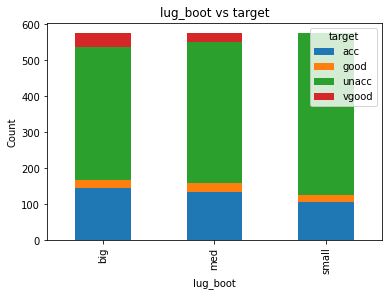

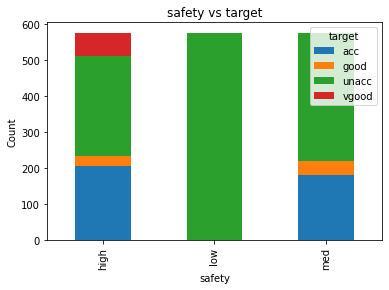

In [ ]:
for feature in X.columns:
    count_matrix = df.groupby([feature, y.target]).size().unstack()
    count_matrix.plot(kind='bar', stacked=True)
    plt.ylabel('Count')
    plt.title(feature + ' vs target')
    plt.show()

We can tell that all 2 person and low safety cars are unacceptable. 

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

class PipelineWrapper:
    def __init__(self, pipeline):
        self.pipeline = pipeline
        self.label_encoder = LabelEncoder()

    def fit(self, X, y):
        self.y_encoded = self.label_encoder.fit_transform(y)
        self.pipeline.fit(X, self.y_encoded)
        return self

    def predict(self, X):
        return self.label_encoder.inverse_transform(self.pipeline.predict(X))

    def transform(self, X):
        return self.pipeline.transform(X)

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [ ]:
categorical_features = ['safety', 'lug_boot', 'maint', 'buying', 'persons', 'doors']  # Replace with your categorical column names
categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features)
    ], remainder='passthrough'
    )

clf = PipelineWrapper(RandomForestClassifier())

full_pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', clf)
])

wrapped_pipeline = PipelineWrapper(full_pipeline)
wrapped_pipeline.fit(X_train, y_train)
y_pred = wrapped_pipeline.predict(X_test)

c:\Users\samue\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)
print('Accuracy: ', accuracy)


Accuracy:  0.9826589595375722


In [ ]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_test_encoded = le.fit_transform(y_test)

c:\Users\samue\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_label.py:115: DataConversionWarning:

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().



In [ ]:
predictions = wrapped_pipeline.predict(X_test)
print(type(predictions[0]))
predictions_encoded = le.transform(predictions)

<class 'str'>


In [ ]:
def custom_predict(model, X):
    predictions = model.predict(X)
    return le.transform(predictions)

car_explainer = dx.Explainer(model=wrapped_pipeline, data=X_test, y=y_test_encoded, predict_function=custom_predict)

Preparation of a new explainer is initiated

  -> data              : 346 rows 6 cols
  -> target variable   : 346 values
  -> model_class       : __main__.PipelineWrapper (default)
  -> label             : Not specified, model's class short name will be used. (default)
  -> predict function  : <function custom_predict at 0x00000189B151BE20> will be used
  -> predict function  : Accepts only pandas.DataFrame, numpy.ndarray causes problems.
  -> predicted values  : min = 0.0, mean = 1.56, max = 3.0
  -> model type        : regression will be used (default)
  -> residual function : difference between y and yhat (default)
  -> residuals         : min = -1.0, mean = 0.0116, max = 2.0
  -> model_info        : package __main__

A new explainer has been created!


In [ ]:
model_performance = car_explainer.model_performance()
model_performance.plot()



In [ ]:
variable_importance = car_explainer.model_parts()
variable_importance.plot()


In [ ]:
prediction_breakdown = car_explainer.predict_parts(X_test.iloc[0])
prediction_breakdown.plot()
